In [1]:
import pickle
from keras.layers import Input, Dense, LeakyReLU, LSTM, CuDNNLSTM, Embedding, Concatenate
from keras.models import Model
from sklearn.preprocessing import StandardScaler
from keras.optimizers import Adam
import numpy as np
from scipy.stats import describe
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from keras.callbacks import TensorBoard
from time import time
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

Using TensorFlow backend.


In [3]:
data = pickle.load(open("processed_data.pkl", "rb"))

In [2]:
possible_tags = pickle.load(open("possible_tags.pkl", "rb"))

In [4]:
base = data["base"]
labels = data["tags"]
use = data["use"]
description = data["description"]

In [5]:
num_datapoints = len(base)
test_cutoff = int(num_datapoints * 0.8)
val_cutoff = int(test_cutoff * 0.8)

base_train, base_test = base[:test_cutoff], base[test_cutoff:]
base_train, base_val = base_train[:val_cutoff], base_train[val_cutoff:]

labels_train, labels_test = labels[:test_cutoff], labels[test_cutoff:]
labels_train, labels_val = labels_train[:val_cutoff], labels_train[val_cutoff:]

use_train, use_test = use[:test_cutoff], use[test_cutoff:]
use_train, use_val = use_train[:val_cutoff], use_train[val_cutoff:]

description_train, description_test = description[:test_cutoff], description[test_cutoff:]
description_train, description_val = description_train[:val_cutoff], description_train[val_cutoff:]

In [6]:
scaler = StandardScaler()
base_train = scaler.fit_transform(base_train)
base_val = scaler.transform(base_val)
base_test = scaler.transform(base_test)

In [53]:
inputs = Input(shape=(4239,))

x = Dense(2000)(inputs)
x = LeakyReLU()(x)
x = Dense(1000)(x)
x = LeakyReLU()(x)
x = Dense(500)(x)
x = LeakyReLU()(x)
x = Dense(250)(x)
x = LeakyReLU()(x)
x = Dense(125)(x)
x = LeakyReLU()(x)
x = Dense(50)(x)
x = LeakyReLU()(x)
predictions = Dense(25, activation="sigmoid")(x)

model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer=Adam(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(base_train, labels_train, epochs=4, validation_data=(base_val, labels_val))
# 0.1796

Train on 49249 samples, validate on 12313 samples
Epoch 1/4
49249/49249 [==============================] - 59s - loss: 0.1940 - acc: 0.9331 - val_loss: 0.1780 - val_acc: 0.9335
Epoch 2/4
49249/49249 [==============================] - 57s - loss: 0.1576 - acc: 0.9415 - val_loss: 0.2013 - val_acc: 0.9316
Epoch 3/4
49249/49249 [==============================] - 57s - loss: 0.1625 - acc: 0.9423 - val_loss: 0.1725 - val_acc: 0.9381
Epoch 4/4
49249/49249 [==============================] - 58s - loss: 0.1429 - acc: 0.9452 - val_loss: 0.1796 - val_acc: 0.9373


In [52]:
print(model.predict(base_val)[0])
print(labels_val[0])

[  6.00202307e-02   1.23588201e-02   2.21241899e-02   1.66401155e-02
   1.58677157e-02   8.02308228e-03   4.88363556e-04   1.74549618e-03
   9.84135091e-01   6.94148103e-03   1.39666591e-02   1.05631605e-01
   4.28205775e-03   4.67755869e-02   7.27817300e-04   8.60025510e-02
   1.84542767e-03   4.82510254e-02   3.11902333e-02   4.31904942e-02
   4.28058393e-03   2.60848422e-02   4.69382430e-05   8.07898104e-01
   2.29361728e-02]
[1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0]


In [9]:
index = 0
percentage = sum(labels_train[:,index])/len(labels_train)
print(sum(labels_val[:,index])/len(labels_val))
print(max(1-percentage, percentage))
print(1/percentage)
print(possible_tags[index])
print(sum(labels_val[:,index]))
lr = 0.001*percentage

0.046942256152
0.949927917318
19.9712084347
#Single
578


In [10]:
base_input = Input(shape=(4239,))

x = Dense(2000)(base_input)
x = LeakyReLU()(x)
x = Dense(1000)(x)
x = LeakyReLU()(x)

y = Dense(2000)(base_input)
y = LeakyReLU()(y)
y = Dense(1000)(y)
y = LeakyReLU()(y)

use_input = Input(shape=(55,))
use_input_embedded = Embedding(10368, 256, input_length=55)(use_input)

use_lstm = CuDNNLSTM(1000, return_state=True)(use_input_embedded, initial_state=[x, y])

use_lstm_c = Dense(1000)(use_lstm[1])
use_lstm_h = Dense(1000)(use_lstm[2])


description_input = Input(shape=(500,))
description_input_embedded = Embedding(61806, 512, input_length=500)(description_input)
description_lstm = CuDNNLSTM(1000)(description_input_embedded, initial_state=[use_lstm_c, use_lstm_h])

output = Concatenate()([base_input, use_lstm[0], description_lstm])
output = Dense(2048)(output)
output = LeakyReLU()(output)
output = Dense(1024)(output)
output = LeakyReLU()(output)
output = Dense(512)(output)
output = LeakyReLU()(output)
output = Dense(256)(output)
output = LeakyReLU()(output)
output = Dense(128)(output)
output = LeakyReLU()(output)
output = Dense(64)(output)
output = LeakyReLU()(output)
output = Dense(32)(output)
output = LeakyReLU()(output)
output = Dense(16)(output)
output = LeakyReLU()(output)
output = Dense(8)(output)
output = LeakyReLU()(output)
output = Dense(4)(output)
output = LeakyReLU()(output)
output = Dense(2)(output)
output = LeakyReLU()(output)
output = Dense(1, activation="sigmoid")(output)

model = Model(inputs=[base_input, use_input, description_input], outputs=output)
model.compile(optimizer=Adam(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit([base_train, use_train[:,:55], description_train[:,:500]],
          labels_train[:,index], epochs=1, validation_data=([base_val, use_val[:,:55],
                                                      description_val[:,:500]], labels_val[:,index]),
         batch_size=10, 
         verbose=1)
# 0.1578
# 97955
# 0.2118

# 0.1744, 0.1739, .1725
# 14.5
# By 4992 -> 0.2333
# 0.1644

# threshold: 0.99175748541
# 6 epochs
# by 790 hits .93?

# 0.7566, 0.9531

# lag at 0.20

Train on 49249 samples, validate on 12313 samples
Epoch 1/1

14570/49249 [=======>......................] - ETA: 20:11 - loss: 0.1835 - acc: 0.9487

KeyboardInterrupt: 

In [9]:
model.fit([base_train, use_train[:,:55], description_train[:,:500]],
          labels_train[:,index], epochs=1, validation_data=([base_val, use_val[:,:55],
                                                      description_val[:,:500]], labels_val[:,index]),
         batch_size=10)

Train on 49249 samples, validate on 12313 samples
Epoch 1/1

17770/49249 [=========>....................] - ETA: 18:55 - loss: 0.1769 - acc: 0.9503

KeyboardInterrupt: 

In [22]:
model.optimizer.lr = 0.0001

In [11]:
model.evaluate([base_val, use_val[:,:55], description_val[:,:500]], labels_val[:,index])


12313/12313 [==============================] - ETA: 0s


[0.10452636716565367, 0.96629578494274349]

In [ ]:
predictions = model.predict([base_val, use_val[:,:55], description_val[:,:500]])

In [14]:
print(use.shape)
print(description.shape)
print(use.shape[1] + description.shape[1] + 4239)

(76953, 645578)
(76953, 11158133)
11807950


In [8]:
index = 0
percentage = sum(labels_train[:,index])/len(labels_train)
print(sum(labels_val[:,index])/len(labels_val))
print(max(1-percentage, percentage))
print(1/percentage)
print(possible_tags[index])
print(sum(labels_val[:,index]))
lr = 0.001*percentage

0.046942256152
0.949927917318
19.9712084347
#Single
578


In [16]:
base_input = Input(shape=(4239,))
base_dense = Dense(1)(base_input)

use_input = Input(shape=(645578,), sparse=True)
use_dense = Dense(1)(use_input)

description_input = Input(shape=(11158133,), sparse=True)
description_dense = Dense(8)(description_input)

output = Concatenate()([base_dense, use_dense, description_dense])
# output = Dense(2**15)(output)
# output = LeakyReLU()(output)
# output = Dense(2**14)(output)
# output = LeakyReLU()(output)
# output = Dense(2**13)(output)
# output = LeakyReLU()(output)
# output = Dense(2**12)(output)
# output = LeakyReLU()(output)
# output = Dense(2**11)(output)
# output = LeakyReLU()(output)
# output = Dense(2**10)(output)
# output = LeakyReLU()(output)
# output = Dense(2**9)(output)
# output = LeakyReLU()(output)
# output = Dense(2**8)(output)
# output = LeakyReLU()(output)
# output = Dense(2**7)(output)
# output = LeakyReLU()(output)
# output = Dense(2**6)(output)
# output = LeakyReLU()(output)
# output = Dense(2**5)(output)
# output = LeakyReLU()(output)
# output = Dense(2**4)(output)
# output = LeakyReLU()(output)
# output = Dense(2**3)(output)
# output = LeakyReLU()(output)
# output = Dense(2**2)(output)
# output = LeakyReLU()(output)
# output = Dense(2**1)(output)
# output = LeakyReLU()(output)
output = Dense(1, activation="sigmoid")(output)

model = Model(inputs=[base_input, use_input, description_input], outputs=output)
model.compile(optimizer=Adam(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit([base_train, use_train, description_train],
          labels_train[:,index], epochs=1,
         batch_size=4, 
         verbose=1)

Epoch 1/1


ResourceExhaustedError: OOM when allocating tensor with shape[11158133,8]
	 [[Node: dense_35/random_uniform/RandomUniform = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=87654321, seed2=4343778, _device="/job:localhost/replica:0/task:0/gpu:0"](dense_35/random_uniform/shape)]]

Caused by op 'dense_35/random_uniform/RandomUniform', defined at:
  File "/home/thomas/anaconda3/envs/kiva/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/thomas/anaconda3/envs/kiva/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/thomas/anaconda3/envs/kiva/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/thomas/anaconda3/envs/kiva/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/thomas/anaconda3/envs/kiva/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/thomas/anaconda3/envs/kiva/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/thomas/anaconda3/envs/kiva/lib/python3.6/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/thomas/anaconda3/envs/kiva/lib/python3.6/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/thomas/anaconda3/envs/kiva/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/thomas/anaconda3/envs/kiva/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/thomas/anaconda3/envs/kiva/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/thomas/anaconda3/envs/kiva/lib/python3.6/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/thomas/anaconda3/envs/kiva/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/thomas/anaconda3/envs/kiva/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/thomas/anaconda3/envs/kiva/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/thomas/anaconda3/envs/kiva/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/thomas/anaconda3/envs/kiva/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/thomas/anaconda3/envs/kiva/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/thomas/anaconda3/envs/kiva/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/thomas/anaconda3/envs/kiva/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-e90c6a1c6c0f>", line 8, in <module>
    description_dense = Dense(8)(description_input)
  File "/home/thomas/anaconda3/envs/kiva/lib/python3.6/site-packages/Keras-2.0.8-py3.6.egg/keras/engine/topology.py", line 576, in __call__
    self.build(input_shapes[0])
  File "/home/thomas/anaconda3/envs/kiva/lib/python3.6/site-packages/Keras-2.0.8-py3.6.egg/keras/layers/core.py", line 830, in build
    constraint=self.kernel_constraint)
  File "/home/thomas/anaconda3/envs/kiva/lib/python3.6/site-packages/Keras-2.0.8-py3.6.egg/keras/legacy/interfaces.py", line 87, in wrapper
    return func(*args, **kwargs)
  File "/home/thomas/anaconda3/envs/kiva/lib/python3.6/site-packages/Keras-2.0.8-py3.6.egg/keras/engine/topology.py", line 397, in add_weight
    weight = K.variable(initializer(shape),
  File "/home/thomas/anaconda3/envs/kiva/lib/python3.6/site-packages/Keras-2.0.8-py3.6.egg/keras/initializers.py", line 212, in __call__
    dtype=dtype, seed=self.seed)
  File "/home/thomas/anaconda3/envs/kiva/lib/python3.6/site-packages/Keras-2.0.8-py3.6.egg/keras/backend/tensorflow_backend.py", line 3626, in random_uniform
    dtype=dtype, seed=seed)
  File "/home/thomas/anaconda3/envs/kiva/lib/python3.6/site-packages/tensorflow/python/ops/random_ops.py", line 240, in random_uniform
    shape, dtype, seed=seed1, seed2=seed2)
  File "/home/thomas/anaconda3/envs/kiva/lib/python3.6/site-packages/tensorflow/python/ops/gen_random_ops.py", line 247, in _random_uniform
    seed=seed, seed2=seed2, name=name)
  File "/home/thomas/anaconda3/envs/kiva/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/thomas/anaconda3/envs/kiva/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/thomas/anaconda3/envs/kiva/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[11158133,8]
	 [[Node: dense_35/random_uniform/RandomUniform = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=87654321, seed2=4343778, _device="/job:localhost/replica:0/task:0/gpu:0"](dense_35/random_uniform/shape)]]


In [17]:
labels_train[:,index].shape

(49249,)

In [ ]:
thresholds = []
for i in range(25):
    print(i)
    precision_recall_curve(labels_val[:,i], predictions[:,i])

55.0


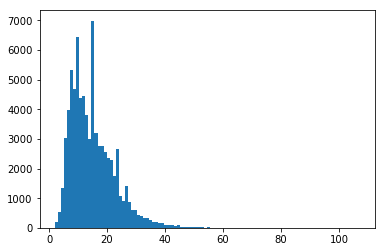

In [40]:
counts = []
for i in use:
    counts.append(len(i[i!=0]))
print(np.percentile(counts, 99.95))
plt.hist(counts, bins=100)
plt.show()

In [31]:
description[:,:500].shape

(76953, 500)